In [ ]:
!pip install torch_geometric torch_sparse torch_scatter torch_cluster torch_spline_conv h5py -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... canceled
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 377, in run
    requirement_set = resolver.resolve(
                      ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 95, in resolve
    result = self._result = resolver.resolve(
                          

In [1]:
!pip install h5py

In [3]:
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt

In [4]:
# ========== LECTURA DE DATASET DE ENTRADA (final_tensor_temporal) ==========

with h5py.File("data_temporal.h5", "r") as h5_file:
    num_nodes = len(h5_file.keys())  # p.ej. 146
    node_tensors = []

    for key in range(num_nodes):
        data = h5_file[str(key)][()]  # shape (410, 81)
        time_steps = data.shape[0]

        # Construimos ventanas deslizantes de tamaño 4
        sliding_windows = []
        for t in range(4, time_steps):
            window = data[t-4:t]  # (4, 81)
            sliding_windows.append(window)

        # (time_steps-4, 4, 81)
        node_tensor = np.stack(sliding_windows)
        node_tensors.append(node_tensor)

    # node_tensors es una lista de length = num_nodes
    # cada elemento con shape (time_steps-4, 4, 81)
    # Apilamos en dim=1 => (num_ventanas, num_nodes, 4, 81)
    final_tensor_temporal = np.stack(node_tensors, axis=1)

# final_tensor_temporal: (num_ventanas=406, num_nodes=146, 4, 81)
print("Shape del tensor final (X):", final_tensor_temporal.shape)

# ========== LECTURA DE DATASET DE SALIDA (final_output_tensor) ==========

with h5py.File("data_temporal.h5", "r") as h5_file:
    num_nodes = len(h5_file.keys())
    output_tensors = []

    for key in range(num_nodes):
        data = h5_file[str(key)][()]  # (410, 81)
        time_steps = data.shape[0]

        targets = []
        for t in range(4, time_steps):
            target = data[t]  # (81,)
            targets.append(target)

        # (time_steps-4, 81) => reshape a (time_steps-4, 1, 81)
        node_targets = np.array(targets).reshape(-1, 1, 81)
        output_tensors.append(node_targets)

    # Apilamos en dim=1 => (num_ventanas=406, num_nodes=146, 1, 81)
    final_output_tensor = np.stack(output_tensors, axis=1)

print("Shape del tensor final (Y):", final_output_tensor.shape)



Shape del tensor final (X): (406, 146, 4, 81)
Shape del tensor final (Y): (406, 146, 1, 81)


In [5]:
class SpatioTemporalDataset(Dataset):
    """
    Devuelve:
       x: (num_nodos, 4, 81)
       y: (num_nodos, 1, 81)
    para cada índice en [0..num_muestras-1]
    """
    def __init__(self, input_data, output_data):
        # input_data: shape (num_muestras, num_nodos, 4, 81)
        # output_data: shape (num_muestras, num_nodos, 1, 81)
        self.input_data = torch.tensor(input_data, dtype=torch.float32)
        self.output_data = torch.tensor(output_data, dtype=torch.float32)

    def __len__(self):
        return self.input_data.shape[0]

    def __getitem__(self, idx):
        return self.input_data[idx], self.output_data[idx]

# Creamos dataset completo
dataset = SpatioTemporalDataset(final_tensor_temporal, final_output_tensor)

# División train/val/test por orden temporal estricto
num_samples = len(dataset)  # p.ej. 406
train_size = int(0.8 * num_samples)  # 80% para train
val_size = int(0.1 * num_samples)    # 10% para val
test_size = num_samples - train_size - val_size

train_indices = list(range(0, train_size))
val_indices = list(range(train_size, train_size + val_size))
test_indices = list(range(train_size + val_size, num_samples))

train_subset = Subset(dataset, train_indices)
val_subset = Subset(dataset, val_indices)
test_subset = Subset(dataset, test_indices)

# Calculamos min y max en el conjunto de entrenamiento
train_input = dataset.input_data[train_indices]  # shape (train_size, num_nodes, 4, 81)
train_output = dataset.output_data[train_indices] # shape (train_size, num_nodes, 1, 81)

input_min = torch.amin(train_input, dim=(0,1,2), keepdim=False)  # shape (81,)
input_max = torch.amax(train_input, dim=(0,1,2), keepdim=False)  # shape (81,)

output_min = torch.amin(train_output, dim=(0,1,2), keepdim=False) # shape (81,)
output_max = torch.amax(train_output, dim=(0,1,2), keepdim=False) # shape (81,)

# Dataset normalizado
class NormalizedDataset(Dataset):
    def __init__(self, subset, input_min, input_max, output_min, output_max):
        self.subset = subset
        self.input_min = input_min
        self.input_max = input_max
        self.output_min = output_min
        self.output_max = output_max

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        x, y = self.subset[idx]
        # x: (num_nodos, 4, 81)
        # y: (num_nodos, 1, 81)

        # Normalizamos en la dimensión de features (81)
        # Reordenamos x a (num_nodos, 4, 81)
        # Expand para poder restar y dividir broadcast
        x_norm = (x - self.input_min) / (self.input_max - self.input_min + 1e-8)
        y_norm = (y - self.output_min) / (self.output_max - self.output_min + 1e-8)

        return x_norm, y_norm

train_dataset = NormalizedDataset(train_subset, input_min, input_max, output_min, output_max)
val_dataset   = NormalizedDataset(val_subset,   input_min, input_max, output_min, output_max)
test_dataset  = NormalizedDataset(test_subset,  input_min, input_max, output_min, output_max)

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

print("Train samples:", len(train_dataset))
print("Val samples:  ", len(val_dataset))
print("Test samples: ", len(test_dataset))


Train samples: 324
Val samples:   40
Test samples:  42


In [6]:
class NodeLevelLSTM(nn.Module):
    def __init__(self, input_dim=81, hidden_dim=64, output_dim=81):
        super().__init__()
        # LSTM: input_dim=81, hidden_dim=64, 1 capa
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True
        )
        # Capa final para mapear hidden_dim -> output_dim
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        """
        x: (batch_size, num_nodos, 4, 81)
        Devuelve: (batch_size, num_nodos, 1, 81)
        """
        batch_size, num_nodes, seq_len, feat_dim = x.shape

        # Prealocamos salida
        out = torch.zeros(batch_size, num_nodes, 1, feat_dim, device=x.device)

        # Iteramos por batch y nodo
        for b in range(batch_size):
            for n in range(num_nodes):
                # (4,81)
                x_bn = x[b, n]  # secuencia temporal para un nodo
                # Añadimos dimensión batch=1 => (1,4,81)
                x_bn = x_bn.unsqueeze(0)

                # LSTM
                lstm_out, (h_n, c_n) = self.lstm(x_bn)
                # Tomamos la última salida de la secuencia => lstm_out[:, -1, :] = (1, hidden_dim)
                last_hidden = lstm_out[:, -1, :]  # (1, hidden_dim)

                # Paso final lineal => (1, 81)
                y_bn = self.fc(last_hidden)

                # Guardamos en out[b,n,0,:]
                out[b, n, 0, :] = y_bn

        return out


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

model = NodeLevelLSTM(input_dim=81, hidden_dim=64, output_dim=81).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

num_epochs = 50
best_val_loss = float("inf")
best_model_state_dict = None

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        # Forward
        y_pred = model(x)  # (batch, num_nodos, 1, 81)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validación
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            val_loss += criterion(y_pred, y).item()

    val_loss /= len(val_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

    # Guardado del mejor modelo
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state_dict = model.state_dict()

if best_model_state_dict is not None:
    torch.save(best_model_state_dict, "Mejor_modelo_lstm_nodos.pth")
    print("Se guardó el mejor modelo con val_loss =", best_val_loss)


Usando dispositivo: cpu
Epoch [1/50] - Train Loss: 0.0090 - Val Loss: 0.0075
Epoch [2/50] - Train Loss: 0.0056 - Val Loss: 0.0049
Epoch [3/50] - Train Loss: 0.0040 - Val Loss: 0.0042
Epoch [4/50] - Train Loss: 0.0036 - Val Loss: 0.0040
Epoch [5/50] - Train Loss: 0.0035 - Val Loss: 0.0038
Epoch [6/50] - Train Loss: 0.0033 - Val Loss: 0.0036
Epoch [7/50] - Train Loss: 0.0032 - Val Loss: 0.0035
Epoch [8/50] - Train Loss: 0.0030 - Val Loss: 0.0033
Epoch [9/50] - Train Loss: 0.0029 - Val Loss: 0.0032
Epoch [10/50] - Train Loss: 0.0027 - Val Loss: 0.0030
Epoch [11/50] - Train Loss: 0.0026 - Val Loss: 0.0029
Epoch [12/50] - Train Loss: 0.0025 - Val Loss: 0.0028
Epoch [13/50] - Train Loss: 0.0024 - Val Loss: 0.0027
Epoch [14/50] - Train Loss: 0.0023 - Val Loss: 0.0026
Epoch [15/50] - Train Loss: 0.0022 - Val Loss: 0.0025
Epoch [16/50] - Train Loss: 0.0022 - Val Loss: 0.0025
Epoch [17/50] - Train Loss: 0.0021 - Val Loss: 0.0024
Epoch [18/50] - Train Loss: 0.0021 - Val Loss: 0.0024
Epoch [19/50]

In [8]:
# Carga del mejor modelo
model.load_state_dict(torch.load("Mejor_modelo_lstm_nodos.pth"))
model.eval()

test_loss = 0.0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        test_loss += criterion(y_pred, y).item()

test_loss /= len(test_loader)
print(f"Pérdida en Test: {test_loss:.4f}")


<ipython-input-8-7ea25c562c81>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("Mejor_modelo_lstm_nodos.pth"))


Pérdida en Test: 0.0015


<ipython-input-12-2281f59a23d6>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("Mejor_modelo_lstm_nodos.pth"))


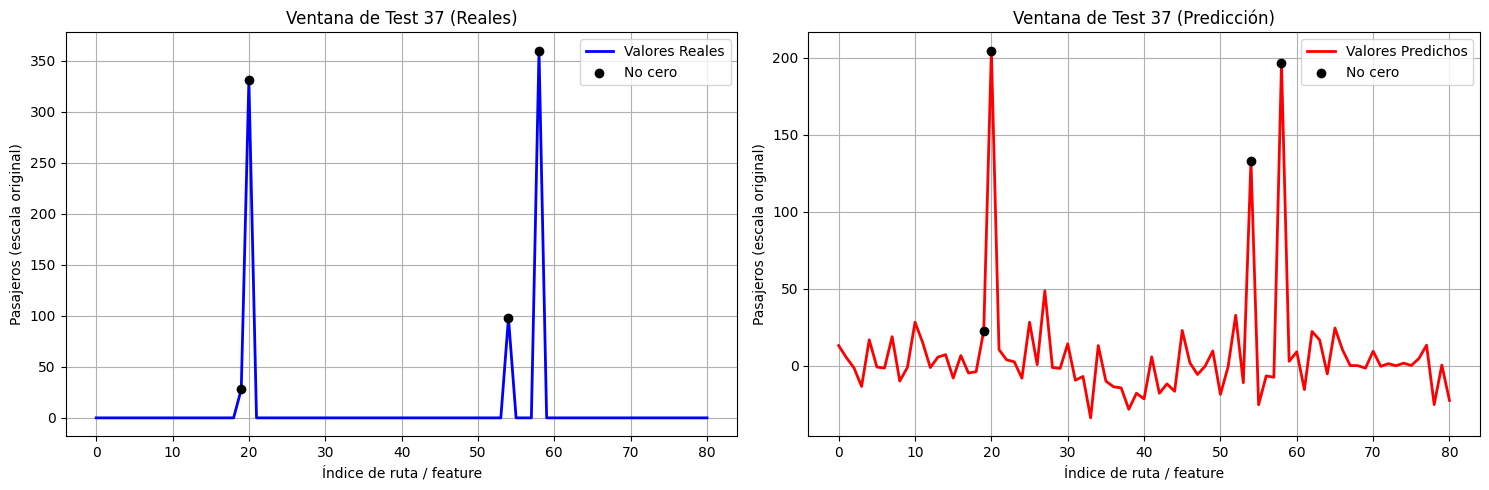

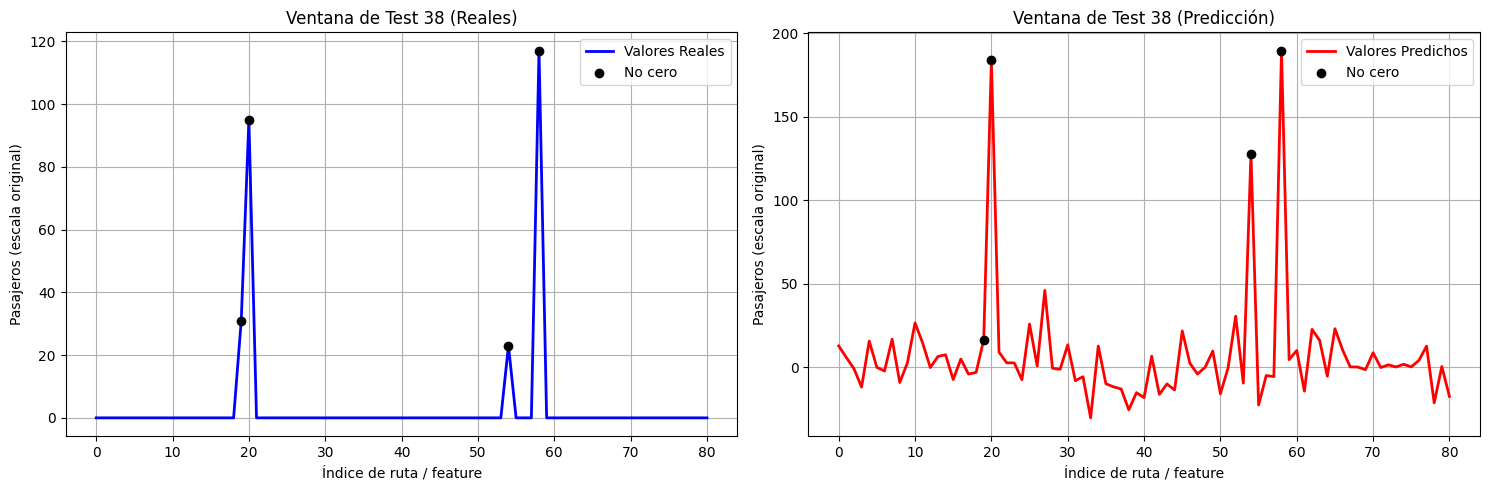

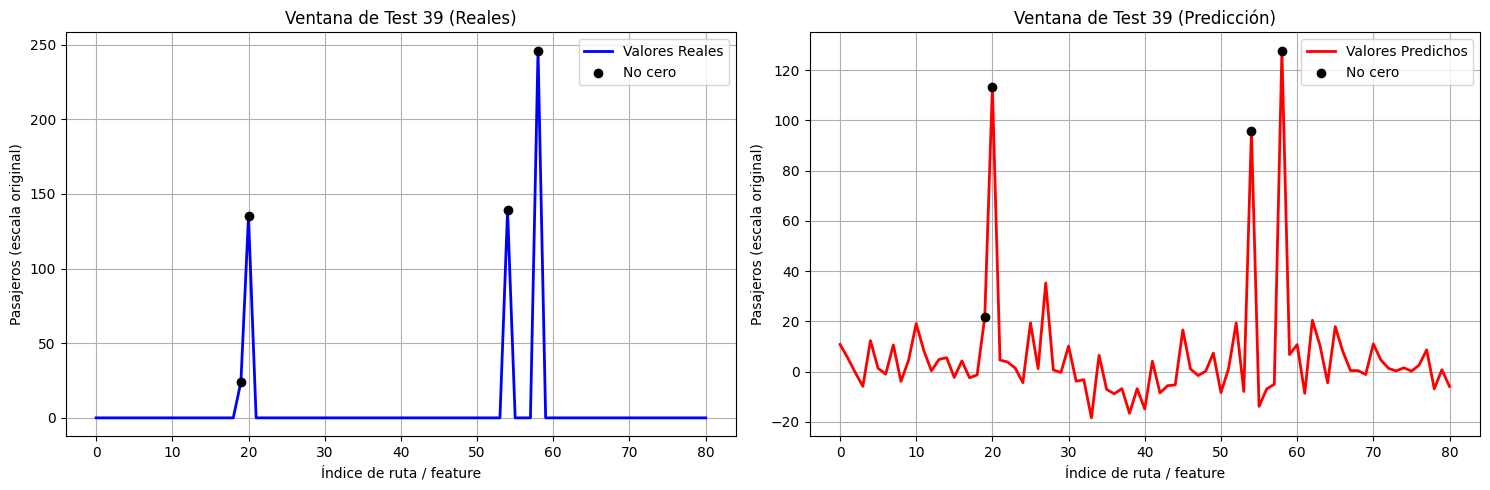

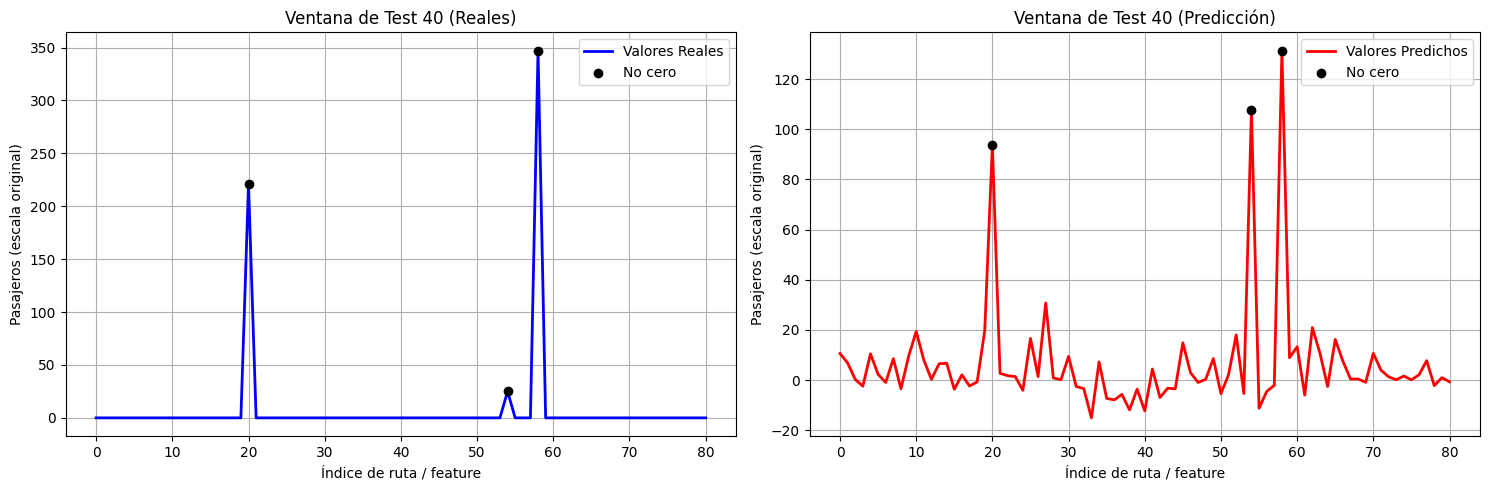

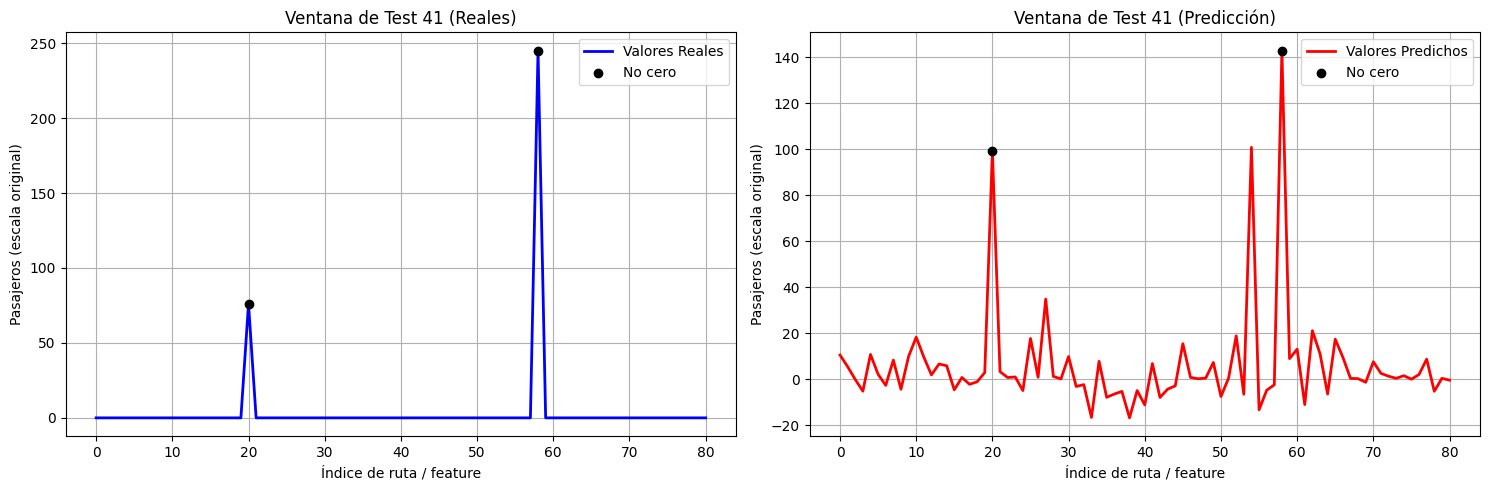

In [12]:
# Prepara un loader con las últimas 5 muestras del test
from torch.utils.data import Subset

model.load_state_dict(torch.load("Mejor_modelo_lstm_nodos.pth"))
model.eval()

test_size = len(test_dataset)
last_5_indices = list(range(test_size - 5, test_size))
last_5_subset = Subset(test_dataset, last_5_indices)
last_5_loader = DataLoader(last_5_subset, batch_size=5, shuffle=False)

nodo_idx = 130  # Escoge el nodo que desees graficar
predictions_original = []
true_values_original = []

with torch.no_grad():
    for x_norm, y_norm in last_5_loader:
        x_norm, y_norm = x_norm.to(device), y_norm.to(device)
        y_pred_norm = model(x_norm)

        # Desnormaliza
        # y_norm = (y - min) / (max-min)
        # => y = y_norm*(max-min) + min
        # Recuerda que output_min/output_max tienen shape (81,)
        # Expandimos para broadcast
        y_pred = y_pred_norm * (output_max - output_min).to(device) + output_min.to(device)
        y_real = y_norm * (output_max - output_min).to(device) + output_min.to(device)

        predictions_original.append(y_pred.cpu())
        true_values_original.append(y_real.cpu())

predictions_original = torch.cat(predictions_original, dim=0)  # (5, num_nodos, 1, 81)
true_values_original = torch.cat(true_values_original, dim=0)  # (5, num_nodos, 1, 81)

# Extraemos datos del nodo 'nodo_idx'
pred_node = predictions_original[:, nodo_idx, 0, :]  # (5, 81)
true_node = true_values_original[:, nodo_idx, 0, :]  # (5, 81)

for i in range(5):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Valores reales
    ax1.plot(true_node[i].numpy(), 'b-', label='Valores Reales', linewidth=2)
    non_zero_idx = np.where(true_node[i].numpy() != 0)[0]
    ax1.scatter(non_zero_idx, true_node[i][non_zero_idx].numpy(),
                color='black', label='No cero', zorder=5)
    ax1.set_title(f"Ventana de Test {test_size - 5 + i} (Reales)")
    ax1.set_xlabel("Índice de ruta / feature")
    ax1.set_ylabel("Pasajeros (escala original)")
    ax1.grid(True)
    ax1.legend()

    # Valores predichos
    ax2.plot(pred_node[i].numpy(), 'r-', label='Valores Predichos', linewidth=2)
    ax2.scatter(non_zero_idx, pred_node[i][non_zero_idx].numpy(),
                color='black', label='No cero', zorder=5)
    ax2.set_title(f"Ventana de Test {test_size - 5 + i} (Predicción)")
    ax2.set_xlabel("Índice de ruta / feature")
    ax2.set_ylabel("Pasajeros (escala original)")
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()
    plt.close()
